## Capstone 4: Unstrucured Learning with Recommendation System for Musical Artistis using Last.fm. 

###    Last.fm website, http://www.lastfm.com 
    @inproceedings{Cantador:RecSys2011,
      author = {Cantador, Iv\'{a}n and Brusilovsky, Peter and Kuflik, Tsvi},
      title = {2nd Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011)},
      booktitle = {Proceedings of the 5th ACM conference on Recommender systems},
      series = {RecSys 2011},
      year = {2011},
      location = {Chicago, IL, USA},
      publisher = {ACM},
      address = {New York, NY, USA},
      keywords = {information heterogeneity, information integration, recommender systems},
   } 

### Credits
   This dataset was built by Ignacio Fernández-Tobías with the collaboration of Iván Cantador and Alejandro Bellogín, 
   members of the Information Retrieval group at Universidad Autonoma de Madrid (http://ir.ii.uam.es)

   
### Contact
   Iván Cantador, ivan [dot] cantador [at] uam [dot] es

#### Why I chose this dataset:  
1) To stretch myself with a dataset that isn't frequently used, and where there are not a lot of recommender examples in contrast to a well known set such as MovieLens.

2) Recommender systems are frequently used in business, and they are of interest to me.  

3) This is similar to capstone 4 suggestion, "Netflix wants to identify similar movies based on movie characteristics." Rather than just output content based recommendations, members in a similar cluster or group, built collaborative and content based filters to recommend an artist based on similarities in ratings.

#### To run slideshow:

jupyter nbconvert Jupyter\ C:\Users\DJ\Documents\AnacondaPython\Thinkful\C4.ipynb --to slides --post serve

### Problem Statement:
After prepocessing data and generating a rating score, identify optimal number of clusters and make artist recommendations based on collaborative and content based clustering.

#### Clustering: cluster user ratings in three genres. 
A) K-Means  
B) Agglomorative  
C) GMM  
D) Dimension Reduction - UMAP  

#### Recommendation Systems: 
A) Collaborative recommendation - Recommend artist based on artist listening to.  
B) Collaborative recommendation - Recommend artist based on similar users.  
C) Content recommendation - Recommend artist based on genre.   

In [1]:
# HIGH LEVEL DATA PLAN

# PREPROCESSING
    # IMPORT DATA
    # BASIC EDA
    # MERGE DIFFERENT FILES INTO ONE DATAFRAME
    # CREATE RANKING SYSTEM BASED ON USER LISTENS# 
    # UNIFY TAGS BY HAVING MOST USED TAG FOR EACH ARTIST BE THE TAG FOR ARTIST

# CLUSTERING 
    # NORMALIZE
    # KMEANS
    # AGGLOMERATIVE CLUSTERING
    # GMM
    # DIMENSION REDUCTION - UMAP

# RECOMMENDER SYSTEMS, COLLABORATIVE FILTERING, CONTENT FILTERING
    #COLLABORATIVE 
        # 1) RECOMMENDATION OF ARTIST BASED ON SIMILARITY TO OTHER ARTISTS
        # 2) RECOMMENDATION OF ARTIST BASED ON SIMILARITY TO OTHER USERS
    # CONTENT BASED
        # GENRE AS CONTENT CHARACTERISTIC. RECOMMEND MOST POPULAR (HIGHEST RATED) IN GENRE

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import time
import os

from scipy.stats import ttest_ind

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
# OUTPUT FILES IN DIRECTORY
print(os.listdir("C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/lastfm_2k"))

['artists.dat', 'lastFM_dj.csv', 'readme.txt', 'tags.dat', 'user_artists.dat', 'user_friends.dat', 'user_taggedartists-timestamps.dat', 'user_taggedartists.dat']


In [4]:
# lOAD TAG FILE. THESE ARE TAGIDs TO TAGS (HASHTAGS) IN ANOTHER FILE
user_taggedartists=pd.read_csv('C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/lastfm_2k/user_taggedartists.dat',
                               sep='\t')

In [5]:
# LOAD USAGE OF ARTIST BY USER FILE. 
user_artists=pd.read_csv('C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/lastfm_2k/user_artists.dat', sep='\t')

In [6]:
# LOAD ARTISTID FILE
artists=pd.read_csv('C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/lastfm_2k/artists.dat', sep='\t')

In [7]:
# LOAD HASHTAG FILE, EX ROCK, POP, DINNER MUSIC, ...
tags=pd.read_csv('C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/lastfm_2k/tags.dat',encoding="ISO-8859-1", sep='\t')

In [8]:
user_taggedartists.head(5)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [9]:
user_taggedartists.shape

(186479, 6)

In [10]:
user_artists.shape

(92834, 3)

In [11]:
# CREATE PRIMARY DATAFRAME, LOAD IN DATA WILL USE
# DROP DAY MONTH YEAR, WON'T USE IN THIS PROJECT
df=user_taggedartists.drop(columns=['day','month','year']).copy()

In [12]:
# PREPARE TO MERGE WEIGHT (NUMBER OF LISTENING EVENTS) BY CREATING A UNIQUE USER/ARTIST ID
df['weight']=''
df['user_artistID'] = df.userID.astype(str) + '_' + df.artistID.astype(str)
user_artists['user_artistID'] = user_artists.userID.astype(str) + '_' + user_artists.artistID.astype(str)
df.head(1)

# MERGE WEIGHT BASED ON MAPPING OF user_artistID COMBO
df['weight'] = df['user_artistID'].map(user_artists.set_index('user_artistID')['weight'])

In [13]:
df['user_artistID'].nunique()

71064

In [14]:
user_artists['user_artistID'].nunique()

92834

In [15]:
df.head(5)

,userID,artistID,tagID,weight,user_artistID
0,2,52,13,11690.0,2_52
1,2,52,15,11690.0,2_52
2,2,52,18,11690.0,2_52
3,2,52,21,11690.0,2_52
4,2,52,41,11690.0,2_52


In [16]:
print("\ncheck shape:\n{}".format(df.shape))
print("\ncheck for nulls:\n{}".format(df.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(df[df.duplicated()].shape))


check shape:
(186479, 5)

check for nulls:
userID           0.000000
artistID         0.000000
tagID            0.000000
weight           0.606615
user_artistID    0.000000
dtype: float64

check for duplicates:
(0, 5)


#### That is a high null percentage in 'weight'. 

What to do about the high null count in 'weight'? 

To recap, created a unique identifier for artist and user in two dataframes. One dataframe had tags for artist inputted by user (ex. 'favorite', 'rock', 'workout'). These tags were tokenized, meaning, for each artist, a user could have many tag entries, or just one. Then the other dataframe represented the count each user listened to each artist. Only one unique pair for each listening 'weight'. 

Then merged the two dataframes on the unique artist user identifier to have tag and weight in same place. 

Did a successful merge.

However, now have large percent of nulls. Since this is a unique identifier, it would appear that there is a material difference in the tag and weight data files. Meaning the files are not synchronized for artist user pairs. One file has tags for artists, but in the listened to file, the user does not have a weight for the artist which the same user allegedly tagged. And vice versa, meaning listened to but didn't tag.   

Significance is need to remove the items with no weight, as need both weight and tag to perform the clustering and recommendations later in project. 

Conclusion. While disappointing, dropping this large of an amount still gives us plenty of data to work with and make a meaningful analysis. There may be some selection bias as a result, but that is acceptiable in this non-business use case.

In [17]:
# DROP WHERE WEIGHTS ARE NULL, NO RATINGS, USER DID NOT LISTEN TO
df = df.dropna(axis=0, subset=['weight'])

In [18]:
df.isnull().mean()

userID           0.0
artistID         0.0
tagID            0.0
weight           0.0
user_artistID    0.0
dtype: float64

In [19]:
df.shape

(73358, 5)

In [20]:
# CREATE ONE TAG FOR EACH ARTIST TO USE AS A REFERENCE POINT TO CLUSTER ON
# THE ONE TAG WILL BE BASED ON MOST FREQUENT TAG ENTERED BY USERS FOR ANY GIVEN ARTIST
# ALT APPROACH: FIND AN INDUSTRY STANDARD MAPPING FOR ARTIST TO MUSIC CATEGORIES

# CREATE A NEW TAG FEATURE
df['tagID_new']=0

# POPULATE GENRE ('tagValue') WITH MOST FREQUENTLY CITED FOR ARTIST
for artist_name in df['artistID'].unique():
    df_temp = df[df['artistID']==artist_name]
    max_tag = df_temp['tagID'].value_counts().idxmax()
    df.loc[(df['artistID'] == artist_name),'tagID_new'] = max_tag

In [21]:
df.head()

,userID,artistID,tagID,weight,user_artistID,tagID_new
0,2,52,13,11690.0,2_52,13
1,2,52,15,11690.0,2_52,13
2,2,52,18,11690.0,2_52,13
3,2,52,21,11690.0,2_52,13
4,2,52,41,11690.0,2_52,13


In [22]:
# lOOK AT NEW TAGS BY ARTIST
grouped = df.groupby(['artistID','tagID_new']).groups

cnt = 0
for artist, tag in grouped:
    cnt += 1
    if cnt < 6:
        print ("artistID: {}\ttagID_new: {}".format(artist,tag))

artistID: 1	tagID_new: 1219
artistID: 2	tagID_new: 575
artistID: 3	tagID_new: 4117
artistID: 4	tagID_new: 139
artistID: 5	tagID_new: 179


In [23]:
# DROP OLD tagID
df.drop(columns='tagID', axis=1, inplace=True)

In [24]:
# WHEN UNIFIED TAG LABELS INTO ONE PER ARTIST, CREATED DUPLICATE

# CHECK FOR DUPLICATES
print("shape prior to dropping duplicates:\n {}".format(df.shape))
# SHAPE OF DUPLICATES:
print("shape of dupplicates prior to dropping duplicates:\n {}".format(df[df.duplicated()].shape))
# DROP DUPLICATES
df.drop_duplicates(keep='first', inplace=True)
# SHAPE AFTER DROPPING DUPLICATES
print("shape after dropping duplicates:\n {}".format(df.shape))
df.shape

shape prior to dropping duplicates:
 (73358, 5)
shape of dupplicates prior to dropping duplicates:
 (52693, 5)
shape after dropping duplicates:
 (20665, 5)


(20665, 5)

In [25]:
print("\ncheck shape:\n{}".format(df.shape))
print("\ncheck for nulls:\n{}".format(df.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(df[df.duplicated()].shape))


check shape:
(20665, 5)

check for nulls:
userID           0.0
artistID         0.0
weight           0.0
user_artistID    0.0
tagID_new        0.0
dtype: float64

check for duplicates:
(0, 5)


In [26]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [27]:
# PREPARE TO MERGE ARTISTS INTO df BY ESTABLISHING artistID, WILL USE TO MAP
artists.columns=['artistID','name','url','pictureURL']

In [28]:
# NOT USING pictureURL, IT IS A URL TO A PICTURE
# MANY OF URL ARE NOT FUNCTIONING AND IS NOT RELEVANT TO CLUSTERING BASED ON GENRE RANKINGS
# THUS, CAN IGNORE NULLS IN pictureURL
print("\ncheck shape:\n{}".format(artists.shape))
print("\ncheck for nulls:\n{}".format(artists.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(artists[artists.duplicated()].shape))


check shape:
(17632, 4)

check for nulls:
artistID      0.000000
name          0.000000
url           0.000000
pictureURL    0.025181
dtype: float64

check for duplicates:
(0, 4)


In [29]:
# GET ARTIST NAME FIELD INTO df BY MAPPING artistID
df['name']=''
df['name'] = df['artistID'].map(artists.set_index('artistID')['name'])
df.head()

,userID,artistID,weight,user_artistID,tagID_new,name
0,2,52,11690.0,2_52,13,Morcheeba
5,2,63,3735.0,2_63,23,Enigma
9,2,73,2584.0,2_73,13,Café Del Mar
17,2,94,1373.0,2_94,15,Ministry of Sound
25,2,96,1342.0,2_96,735,Fleetwood Mac


In [30]:
# LOOK AT TAG IMPORT
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [31]:
# MERGE tagVALUE INTO df BY MAPPING ON tagID WITH tagID_new
df['tagValue']=''
df['tagValue'] = df['tagID_new'].map(tags.set_index('tagID')['tagValue'])

# NOW HAVE NUMERIC IDS FOR TAGS AND ARTIST NAME IN df, 
# TAG CHOSEN BY MOST FREQUENT TAG PLACED BY ALL USERS
df.head()

,userID,artistID,weight,user_artistID,tagID_new,name,tagValue
0,2,52,11690.0,2_52,13,Morcheeba,chillout
5,2,63,3735.0,2_63,23,Enigma,new age
9,2,73,2584.0,2_73,13,Café Del Mar,chillout
17,2,94,1373.0,2_94,15,Ministry of Sound,downtempo
25,2,96,1342.0,2_96,735,Fleetwood Mac,70s


In [32]:
# NAME HAS SOME NULL VALUES
# ARTIST ID AND ARTIST NAME WERE NOT SYNCED IN TWO LOAD FILES, WILL DROP NULL ROWS LATER
print("\ncheck shape:\n{}".format(df.shape))
print("\ncheck for nulls:\n{}".format(df.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(df[df.duplicated()].shape))


check shape:
(20665, 7)

check for nulls:
userID           0.0
artistID         0.0
weight           0.0
user_artistID    0.0
tagID_new        0.0
name             0.0
tagValue         0.0
dtype: float64

check for duplicates:
(0, 7)


In [33]:
print("Number unique Genres : {}".format(df['tagID_new'].nunique()))
print("Number unique Users  : {}".format(df['userID'].nunique()))
print("Number unique Artists: {}".format(df['artistID'].nunique()))

Number unique Genres : 1651
Number unique Users  : 1824
Number unique Artists: 6854


In [34]:
# CREATE DATAFRAME FOR tagValue_cnt.
# THIS WILL BE USED TO GROUP VALUES AND LOOK AT POPULARITY FOR EACH TAG
df_tagValue_cnt=pd.DataFrame()
df_tagValue_cnt['tagValue']=df['tagValue']
df_tagValue_cnt['tagCnt']=1

In [35]:
# CREATE GROUP BY, AND OUTPUT MOST USED TAGS
df_gb = df_tagValue_cnt.groupby(['tagValue']).sum().sort_values(ascending=False, by='tagCnt')
df_gb.head()

,tagCnt
tagValue,
pop,2206
rock,1146
alternative,869
electronic,858
indie,614


### Analysis:
Based on consumption, meaning number of listens, users have voted the top genres to be:
    pop, rock, alternative, electronic, and indie.

In [36]:
# CREATE A RANK FOR THE TAGS (GENRES) SO CAN FILTER FOR MOST FREQUENT
df_gb['tagRank']=0
counter=0
value=0
for index, row in df_gb.iterrows():
    value+=1
    df_gb['tagRank'].iloc[[counter]]=value
    counter+=1

In [37]:
df_gb['tagRank'].head(5)

tagValue
pop            1
rock           2
alternative    3
electronic     4
indie          5
Name: tagRank, dtype: int64

In [38]:
df = pd.merge(df, df_gb, how='left', on=['tagValue', 'tagValue'])

In [39]:
df.describe()

,userID,artistID,weight,tagID_new,tagCnt,tagRank
count,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000
mean,1045.666780,3390.632906,1425.566368,837.964287,489.027196,119.741737
std,620.353435,4519.863040,7064.561155,2144.489820,673.487823,269.069202
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,507.000000,430.000000,172.000000,61.000000,42.000000,5.000000
50%,1029.000000,1243.000000,411.000000,127.000000,164.000000,22.000000
75%,1597.000000,4365.000000,1014.000000,386.000000,614.000000,78.000000
max,2100.000000,18744.000000,352698.000000,12642.000000,2206.000000,1651.000000


In [40]:
df.head()

,userID,artistID,weight,user_artistID,tagID_new,name,tagValue,tagCnt,tagRank
0,2,52,11690.0,2_52,13,Morcheeba,chillout,62,61
1,2,63,3735.0,2_63,23,Enigma,new age,50,71
2,2,73,2584.0,2_73,13,Café Del Mar,chillout,62,61
3,2,94,1373.0,2_94,15,Ministry of Sound,downtempo,122,38
4,2,96,1342.0,2_96,735,Fleetwood Mac,70s,72,52


In [41]:
# BACKUP df
#df_orig = df.copy()

In [42]:
# GET ALL DATA FOR JUST THE TOP 3 TAG RANKINGS INTO A DATAFRAME:  POP, ROCK, ALTERNATIVE
# PURPOSE IS TO REDUCE SIZE OF FEATURES AND USERS
df = df[df['tagRank']<=3]

In [43]:
# PREPARE TO CREATE A PERCENT RANK  
# EACH GENRE WILL BE A PERCENTAGE OF TOTAL  
# ZERO SUM, MEANING A CUMULATIVE TYPE RANKING WHICH SUMS TO 1  
# HAVE THREE GROUPS, LISTENERS HAVE LISTENED TO AT LEAST ONE
# RANK % OF LISTEN ACROSS GROUPS, WITH RESPECT TO OVERALL NUMBER OF LISTENS FOR ALL GROUPS
# INITIALIZE 0.00
df_user_genre=pd.DataFrame()
df_user_genre['userID']=df['userID'].unique()
df_user_genre['cum_weight']=0.00
df_user_genre['cum_rank']=0.00

In [44]:
# CHECK TAGS FOR AN USER
user_num = 10
tags = df[df['userID']==user_num]['tagValue'].unique()
print(tags)

['alternative']


In [45]:
# MAKE % FEATURE CATEGORIES SO CAN USE FOR K-MEANS CLUSTERING, DO IN df_user_genre
for i in df['tagValue'].unique(): 
    pctID = i + '_%'
    df_user_genre[pctID] = 0.00
for i in df['tagValue'].unique(): 
    df_user_genre[i]     = 0.00

In [46]:
# NORMALIZE DATA USING %
# POPULATE FIELDS WITH PERCENTAGES SO DATA IS NORMALIZED PRIOR TO KMEANS AND CLUSTERING
idx=0

for i in df['userID'].unique():
    cum_weight=0
    
    # GET UNIQUE TAGS WITHIN EACH USER
    # COUNT TAGS
    for j in df[df['userID']==i]['tagValue'].unique():
        wgt=df[(df['tagValue'] == j) & (df['userID'] == i)]['weight'].sum()
        df_user_genre.at[idx,j]= wgt
        cum_weight+=wgt
    
    df_user_genre.at[idx,'cum_weight'] = cum_weight
    
    for j in df[df['userID']==i]['tagValue'].unique():
        wgt=df[(df['tagValue'] == j) & (df['userID'] == i)]['weight'].sum()
        pct_wgt = wgt/cum_weight
        string = j + "_%"
        rank_col = string
        df_user_genre.at[idx,rank_col] = pct_wgt
    idx+=1

In [47]:
# CREATE A DATAFRAME WITH USER WHO LISTEN TO ALL THREE CATEGORIES
#df_user_genre[(df_user_genre['pop']>0) & (df_user_genre['rock']>0) & (df_user_genre['indie']>0)].count()

In [48]:
# PRIMARY DATA FRAME CONTENT AFTER PREPROCESSING
df.head()

,userID,artistID,weight,user_artistID,tagID_new,name,tagValue,tagCnt,tagRank
22,4,154,826.0,4_154,79,Radiohead,alternative,869,3
23,4,156,743.0,4_156,79,VAST,alternative,869,3
24,4,157,732.0,4_157,24,Michael Jackson,pop,2206,1
31,4,171,359.0,4_171,73,Stereophonics,rock,1146,2
32,4,173,292.0,4_173,79,Placebo,alternative,869,3


In [49]:
# ANOTHER SIGNIFICANT DATA FRAME WITH % RANKINGS NORMALIZED BETWEEN 0 AND 1 INCLUSIVE
# WEIGHT IS NUMBER OF LISTENING EVENTS, % IS PERCENT OF GENRE TO TOTAL
df_user_genre.head()

,userID,cum_weight,cum_rank,alternative_%,pop_%,rock_%,alternative,pop,rock
0,4,3892.0,0.0,0.478160,0.367934,0.153905,1861.0,1432.0,599.0
1,5,1302.0,0.0,0.849462,0.000000,0.150538,1106.0,0.0,196.0
2,7,43864.0,0.0,0.000000,1.000000,0.000000,0.0,43864.0,0.0
3,8,402.0,0.0,0.000000,1.000000,0.000000,0.0,402.0,0.0
4,9,1149.0,0.0,0.232376,0.000000,0.767624,267.0,0.0,882.0


In [50]:
df_user_genre.isnull().mean()

userID           0.0
cum_weight       0.0
cum_rank         0.0
alternative_%    0.0
pop_%            0.0
rock_%           0.0
alternative      0.0
pop              0.0
rock             0.0
dtype: float64

In [51]:
#df_user_genre = df_user_genre.dropna()

In [52]:
df_user_genre['cum_rank']=df_user_genre['cum_weight']/df_user_genre['cum_weight'].sum()

### K-Means  
Data prerequisites for k-means:
In order to successfully apply k-means to clustering problems, there are three prerequisites the data must meet. If you apply k-means to data that does not meet these assumptions, you will get incorrect, unintuitive results.

1. Cluster number is k K-means assumes that the correct cluster number is k. Since we provide the value of k to k-means, we need to determine the best value. However, most of the time determining k is not trivial and we need to run k-means with several k values and choose the one that makes most sense to us. 

2. Clusters are isotropic K-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward. If this assumption fails, k-means would come up with unuseful clusters. 

3. Similar variance K-means also assumes all clusters have similar variance.

The outcome of k-means can be sensitive to the scale of the data. Normalizing each variable is a common practice before applying k-means.

The results depend on the value of k. So, choosing the correct k is essential for the algorithm to find the correct clusters. 

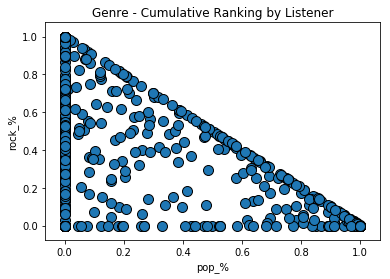

In [53]:
# CREATE ARRAY FOR PERCENTAGE WEIGHT RANK FOR JUST POP AND ROCK GENRES
X = df_user_genre.loc[:,['pop_%','rock_%']].values

# VISUALIZE NORMALIZED DATA WITH SCATTER PLOT
plt.scatter(X[:,0], X[:,1], s = 100, edgecolors='black', marker='o')
plt.title('Genre - Cumulative Ranking by Listener')
plt.xlabel('pop_%')
plt.ylabel('rock_%')
plt.show()

In [54]:
df_user_genre.shape

(1054, 9)

In [55]:
X.shape

(1054, 2)

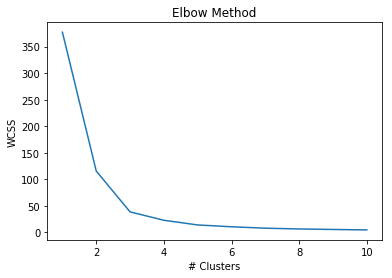

In [56]:
# DETERMINE OPTIMAL CLUSTER NUMBER 
# ELBOW METHOD -> WITHIN CLUSTER SUM OF SQUARES (WCSS)
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

In [57]:
pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(X)
pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(X)
pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(X)
pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(X)
pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(X)

print("Silhouette score for two   cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_3, metric='euclidean')))
print("Silhouette score for four  cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_4, metric='euclidean')))
print("Silhouette score for five  cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_5, metric='euclidean')))

# SILHOUETTE INCREASES WITH CLUSTERS

Silhouette score for two   cluster k-means:	 0.667561317774461
Silhouette score for three cluster k-means:	 0.7287082551855586
Silhouette score for four  cluster k-means:	 0.735636152385852
Silhouette score for five  cluster k-means:	 0.7415966546972222


#### K-Means analysis.
Elbow method suggests three as the best cluster number.
Silhouette score rises with each cluster, but starts to level off at three supporting the general reasoning behind the elbow method which is choose number of clusters when WCSS starts to level off.  

#### Agglomerative Clustering
Ward: The Ward method tends to look for spherical clusters such that the clusters are cohesive inside and differentiated from other groups. In general, this method tends to find clusters of similar size. Note that the Ward method only works with Euclidean distance.  

Complete: The Complete method links clusters using their furthest observations, that is, their most dissimilar data points. Consequently, clusters created using this method tend to be comprised of highly similar observations, making the resulting groups quite compact.  

Average: The Average method links clusters using their centroids. Since this method focuses on centroids and ignoring the boundary points, it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.  

In [58]:
agg_cluster1 = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters1 = agg_cluster1.fit_predict(X)

agg_cluster2 = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters2 = agg_cluster2.fit_predict(X)

agg_cluster3 = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters3 = agg_cluster3.fit_predict(X)

agg_cluster4 = AgglomerativeClustering(linkage='complete', 
                                      affinity='manhattan',
                                      n_clusters=3)
clusters4 = agg_cluster4.fit_predict(X)

agg_cluster5 = AgglomerativeClustering(linkage='average', 
                                      affinity='manhattan',
                                      n_clusters=3)
clusters5 = agg_cluster5.fit_predict(X)

In [59]:
print("Silhoutte - metric = euclidean, linkage = complete :\t {}"
      .format(metrics.silhouette_score(X, clusters1, metric='euclidean')))

print("Silhoutte - metric = euclidean, linkage = average:\t {}"
      .format(metrics.silhouette_score(X, clusters2, metric='euclidean')))

print("Silhoutte - metric = euclidean, linkage = ward:\t\t {}"
      .format(metrics.silhouette_score(X, clusters3, metric='euclidean')))

print("Silhoutte - metric = manhattan, linkage = complete:\t {}"
      .format(metrics.silhouette_score(X, clusters4, metric='manhattan')))

print("Silhoutte - metric = manhattan, linkage = average:\t {}"
      .format(metrics.silhouette_score(X, clusters5, metric='manhattan')))

print("Silhoutte - metric = cosine, linkage = complete:\t {}"
      .format(metrics.silhouette_score(X, clusters4, metric='cosine')))

print("Silhoutte - metric = cosine, linkage = average:\t\t {}"
      .format(metrics.silhouette_score(X, clusters5, metric='cosine')))

# EUCLIDEAN BEST DISTANCE, WARD BEST LINKAGE

Silhoutte - metric = euclidean, linkage = complete :	 0.6921475646630343
Silhoutte - metric = euclidean, linkage = average:	 0.7272870989454674
Silhoutte - metric = euclidean, linkage = ward:		 0.6389041120246003
Silhoutte - metric = manhattan, linkage = complete:	 0.6863754253748112
Silhoutte - metric = manhattan, linkage = average:	 0.7001394540474729
Silhoutte - metric = cosine, linkage = complete:	 0.5840345475806079
Silhoutte - metric = cosine, linkage = average:		 0.508603905012469


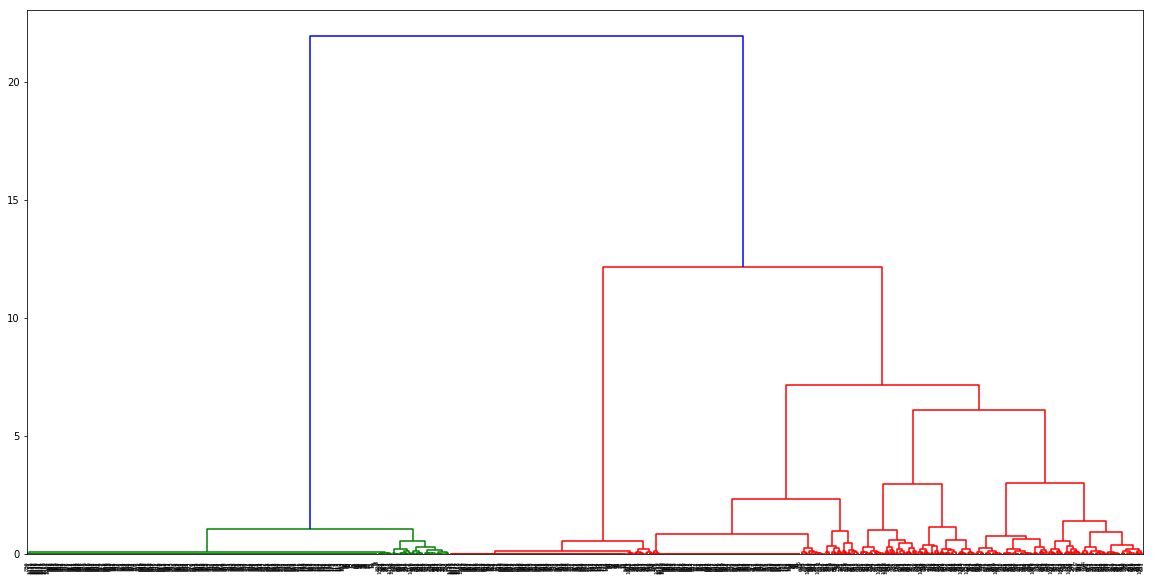

In [60]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='ward'))
plt.show()
# TWO CLUSTERS ARE CHOSEN, BUT THREE ARE NOTICEABLE

#### Agglomerative clustering analysis
Two clusters are chosen.   
Ward is best "method".  

### GMM
There are two important assumptions that GMM makes:

The first one is that there are k distributions that generate the data. In effect, this is equivalent to say that there are exactly k clusters in the data.

The other assumption is that all of these k distributions are Gaussians. However, GMM doesn't put constraints on the parameters of these Gaussians but estimates them such that the likelihood of the data being generated by these k Gaussians is maximized.

GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

full: This is the default. Each component has its own general covariance matrix.    
tied: All components share the same general covariance matrix.  
diag: Each component has its own diagonal covariance matrix.  
spherical: Each component has its own single variance.      

Full: means the components may independently adopt any position and shape.  
Tied: means they have the same shape, but the shape may be anything.  
Diagonal: means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.  
Tied Diagonal: is a "tied" situation where the contour axes are oriented along the coordinate axes. (I have added this because initially it was how I misinterpreted "diagonal.")  
Spherical: is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).  

In [61]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = full:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='tied')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = tied:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='diag')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = diag:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = spherical:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='full')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = full:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='tied')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = tied:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='diag')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = diag:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = spherical:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

# TIED (SAME SHAPE) COVARIANCE TYPE BEST PERFORMER WITH THREE COMPONENTS

Silhoutte - GMM n_components = 3, covariance_type = full:		 0.402
Silhoutte - GMM n_components = 3, covariance_type = tied:		 0.725
Silhoutte - GMM n_components = 3, covariance_type = diag:		 0.402
Silhoutte - GMM n_components = 3, covariance_type = spherical:		 0.465
Silhoutte - GMM n_components = 4, covariance_type = full:		 0.489
Silhoutte - GMM n_components = 4, covariance_type = tied:		 0.734
Silhoutte - GMM n_components = 4, covariance_type = diag:		 0.468
Silhoutte - GMM n_components = 4, covariance_type = spherical:		 0.444


#### GMM Analysis
Four outperforms three clusters across the board. But the highest ranked covariance type is tied.

#### Summary 
Three clusters are optimal.  
K-Means chose three using WCSS, and is the best performing clustering algorithm based on siloutette score. 
Agglomerative, Ward performed the best. Chose two clusters.  
GMM, chose four clusters, best performance came from tied covariance type (uniform shape).   

### DIMENSION REDUCTION

UMAP is fast and can handle large datasets with high-dimensional data. This is its core advantage against the t-SNE method. So, if you have a large high-dimensional data and want to visualize it, you should try UMAP first instead of t-SNE. Moreover, UMAP is usually better at preserving the global structure of the data than t-SNE. This means that it can provide a better "big picture" view of your data as well as preserving local neighbor similarities.

Hyperparameters: UMAP supports a wide variety of distance metrics, including cosine and correlation distances. Hence, the quality of the lower-dimensional representation might be affected by the metric used. We should also specify the number of neighbors and the minimum distance parameters when applying UMAP. As usual, the best way to choose values for these hyperparameters is to apply k-fold cross-validation.

Among the dimensionality reduction algorithms we cover in this module, PCA is the fastest then comes UMAP. So, if you are very time-constrained or your data isn't too complex, you should start with PCA. But if your data is complex like image, text or audio where non-linear relationship between the observations is the norm, then you should go with UMAP as it's more likely that UMAP would produce better representation of your data than PCA.

UMAP minimizes the total cross-entropy using an optimization method like Stochastic Gradient Descent (SGD). This step is an iterative one and continues until convergence.

Output does not appear to be deterministic, like t-SNE, as it changes from run to run. Cannot use in a model, for that use PCA.

In [101]:
#UNIFORM MANIFOLD APPROXIMATION AND PROJECTION
import umap
umap_results = umap.UMAP(metric='correlation').fit_transform(X)

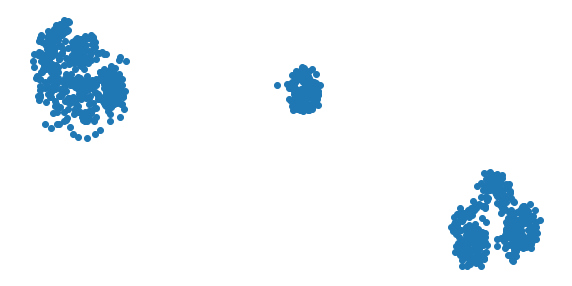

In [102]:
# UMAP DIMENSION REDUCTION USING CORRELATION
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# THREE DISTINCT CLUSTERS ARE NOTICEABLE

In [64]:
# UMAP DIMENSION REDUCTION USING COSINE
umap_results = umap.UMAP(metric='cosine').fit_transform(X)

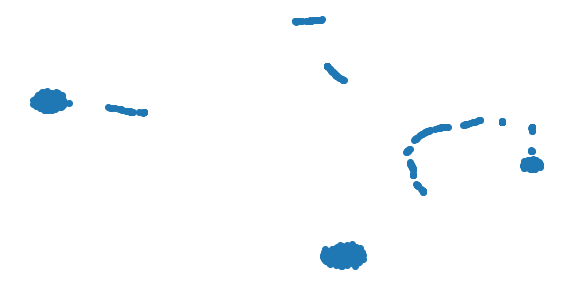

In [65]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# NOT SURE HOW MANY CLUSTERS THIS MAY BE, DOESN'T APPEAR TO BE OF QUALITY

In [66]:
umap_results = umap.UMAP(metric='euclidean').fit_transform(X)

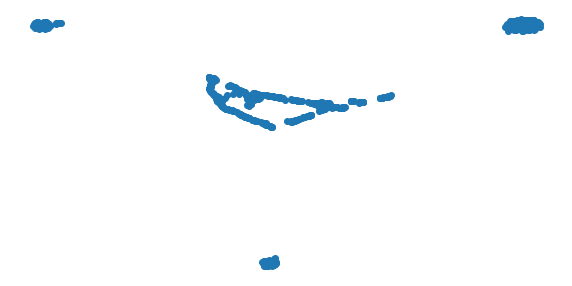

In [67]:
# UMAP DIMENSION REDUCTION USING EUCLIDEAN DISTANCE
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# AT LEAST FOUR CLUSTERS ARE NOTICEABLE.

### Summary - UMAP dimension reduction
Correlation appears to give the best visualization using UMAP, yielding three clusters.
Correlation has most uniform circular output.
UMAP output changes with each run, not deterministic.  

### Summary - Clustering and dimension reduction
Three clusters appear to be the appropriate number of clusters as seen by the elbow method with K-Means.

K = 3 is supported by dimension reduction UMAP visualization which has three distinct blobs.   

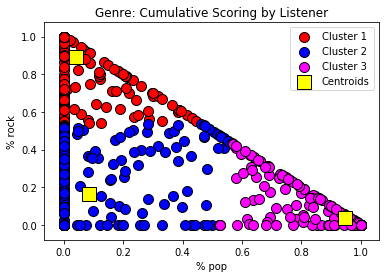

In [68]:
# CHART 3 CLUSTERS 
kmeans = KMeans(n_clusters= 3, init= 'random', max_iter=300, n_init=10,
                random_state=42)
y_kmeans = kmeans.fit_predict(X)
clusters = set(y_kmeans)
colors = ['red', 'blue', 'magenta','grey']
labels = ['Cluster {}'.format(i+1) for i in set(y_kmeans)]
for clust, color, labels in zip(clusters, colors, labels):
    plt.scatter(X[y_kmeans == clust, 0], X[y_kmeans == clust, 1], 
                s=100, c = color, label = labels, edgecolors='black')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s = 200, c = 'yellow', 
            label = 'Centroids', edgecolors='black', marker='s')
plt.title('Genre: Cumulative Scoring by Listener')
plt.xlabel('% pop')
plt.ylabel('% rock')
plt.legend()
plt.show()

In [69]:
# FIT KMEANS ALGORITHM
kmeans = KMeans(n_clusters=3).fit(X)
preds = kmeans.predict(X)

# GET CENTROIDS
centroids = kmeans.cluster_centers_

In [70]:
# DISTANCE FROM CENTROID

from scipy.spatial import distance_matrix

dist_mat = pd.DataFrame(distance_matrix(X, centroids))
dist_mat.groupby(preds).mean()

,0,1,2
0,0.156428,1.248077,0.737094
1,1.245311,0.102287,0.874001
2,0.751004,0.894317,0.223732


In [71]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_user_genre.index.values
cluster_map['cl_label'] = kmeans.labels_

In [72]:
df_user_genre= pd.concat([df_user_genre, cluster_map['cl_label']], axis=1)
df_user_genre= pd.concat([df_user_genre, dist_mat], axis=1)
df_user_genre.head()

,userID,cum_weight,cum_rank,alternative_%,pop_%,rock_%,alternative,pop,rock,cl_label,0,1,2
0,4,3892.0,0.000371,0.478160,0.367934,0.153905,1861.0,1432.0,599.0,2,0.805781,0.589043,0.282943
1,5,1302.0,0.000124,0.849462,0.000000,0.150538,1106.0,0.0,196.0,2,0.740886,0.951928,0.085937
2,7,43864.0,0.004183,0.000000,1.000000,0.000000,0.0,43864.0,0.0,1,1.308692,0.065485,0.929181
3,8,402.0,0.000038,0.000000,1.000000,0.000000,0.0,402.0,0.0,1,1.308692,0.065485,0.929181
4,9,1149.0,0.000110,0.232376,0.000000,0.767624,267.0,0.0,882.0,0,0.129285,1.195403,0.611201


In [73]:
df.head()

,userID,artistID,weight,user_artistID,tagID_new,name,tagValue,tagCnt,tagRank
22,4,154,826.0,4_154,79,Radiohead,alternative,869,3
23,4,156,743.0,4_156,79,VAST,alternative,869,3
24,4,157,732.0,4_157,24,Michael Jackson,pop,2206,1
31,4,171,359.0,4_171,73,Stereophonics,rock,1146,2
32,4,173,292.0,4_173,79,Placebo,alternative,869,3


## START BASIC RECOMMENDER

### COLLABORATIVE FILTER - ARTIST 

In [74]:
# INPUT THE CLUSTER OF INTEREST
cluster_of_interest = 2

In [75]:
from scipy.spatial.distance import cosine, euclidean, correlation

In [76]:
# GET CLUSTER NUMBER INTO df SO CAN LIMIT INPUTS INTO RECOMMENDATION ENGINE
# PURPOSE IS TO LEVERAGE UNSTRUCTURED LEARNING AND GROUP USERS BASED ON CLUSTER 
# THEN RECOMMEND IN CLUSTER
df['cl_label'] = df['userID'].map(df_user_genre.set_index('userID')['cl_label'])

In [77]:
# USE COPY SO WON'T IMPACT WEIGHTS IN df. TREAT LIKE ONEHOTENCODING 
df_preprocess = df[df['cl_label']==cluster_of_interest][['userID','name','weight']].copy()
# SET WEIGHTS EQUAL TO ONE SO DON'T HAVE SCALING ISSUES
df_preprocess['weight']=1
df_preprocess.head()

,userID,name,weight
22,4,Radiohead,1
23,4,VAST,1
24,4,Michael Jackson,1
31,4,Stereophonics,1
32,4,Placebo,1


In [78]:
# COUNT AGGREGATION COLUMN BASED ON ARTISTID
df_preprocess['count'] = df_preprocess.groupby('name')['name'].transform('count')

# ARTIST REQUIRES >=2 EVENTS TO BE CONSIDERED
df_preprocess = df_preprocess[(df_preprocess['count']>=2)]

# OUTPUT UNIQUE ARTISTS SO VALIDATE NO DUPES WHEN PIVOT
df_preprocess['name'].nunique()

161

In [79]:
df_preprocess=df_preprocess.pivot(index='userID', columns='name', values='weight')
df_preprocess=df_preprocess.reset_index()
df_preprocess.shape

(281, 162)

In [80]:
df_preprocess.shape

(281, 162)

In [81]:
df_same_clust=df_preprocess.copy()
#df_same_clust.rename(columns={'userID':'user'}, inplace=True)

In [82]:
df_same_clust.fillna(0,inplace=True)

In [83]:
df_same_clust.head()

name,userID,30 Seconds to Mars,311,ABBA,Adam Lambert,Air Traffic,Alanis Morissette,Alkaline Trio,Anberlin,Architecture in Helsinki,...,Travis,U2,VAST,Ween,Weezer,Zoé,t.A.T.u.,Агата Кристи,Адаптация Пчёл,Психея
0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# ARTISTS AS FEATURES, INDEX  
df_same_clust_no_user = df_same_clust.drop('userID', 1)
 
# CREATE A PLACEHOLDER DATAFRAME FOR ITEM SIMILARITY
df_item_sim_scr = pd.DataFrame(index=df_same_clust_no_user.columns,columns=
                         df_same_clust_no_user.columns)

In [85]:
# ARTIST BASED SIMILARITY - USE COSINE TO MEASURE DISTANCE AND POPULATE
# THE SIMILARITY SCORE IS BASED ON COMPARING LISTENED TO VECTORS OF TWO ARTISTS

# USE COSINE FOR SIMILARITY SCORE
# LOOP COLUMNS
for i in range(0,len(df_item_sim_scr.columns)):
    for j in range(0,len(df_item_sim_scr.columns)):
        # SIMILARITY SCORE
        # COSINE 
        df_item_sim_scr.iloc[i,j] = 1-cosine(df_same_clust_no_user.iloc[:,i],
                                             df_same_clust_no_user.iloc[:,j])
        # CORRELATION
        #df_item_sim_scr.iloc[i,j] = 1-correlation(df_same_clust_no_user.iloc[:,i],
        #                                        df_same_clust_no_user.iloc[:,j])
        # EUCLIDEAN
        #df_item_sim_scr.iloc[i,j] = 1-euclidean(df_same_clust_no_user.iloc[:,i],
        #                                         df_same_clust_no_user.iloc[:,j])

In [86]:
# ARTIST ON ROW AND COLUMN, VALUE IS COSINE SIMILARITY SCORE
# HIGHER SCORE, HIGHER SIMILARITY, 1 IS THE SAME, 0 IS NO RANK
df_item_sim_scr.head()

name,30 Seconds to Mars,311,ABBA,Adam Lambert,Air Traffic,Alanis Morissette,Alkaline Trio,Anberlin,Architecture in Helsinki,Ash,...,Travis,U2,VAST,Ween,Weezer,Zoé,t.A.T.u.,Агата Кристи,Адаптация Пчёл,Психея
name,,,,,,,,,,,,,,,,,,,,,
30 Seconds to Mars,1,0,0.144338,0.166667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.204124,0,0.166667
311,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABBA,0.144338,0,1,0,0,0,0,0,0,0,...,0.133631,0.333333,0,0,0,0,0,0,0,0
Adam Lambert,0.166667,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Air Traffic,0,0,0,0,1,0,0,0,0,0,...,0.188982,0,0,0,0,0,0,0,0,0


In [87]:
# CHECK SIMILARITY SCORE VALUES
df_item_sim_scr.iloc[0:,3].sort_values(ascending=False)[:6]

name
Adam Lambert             1
Mika              0.408248
Kris Allen        0.408248
P!nk              0.333333
Lenny Kravitz     0.333333
Kelly Clarkson    0.333333
Name: Adam Lambert, dtype: object

In [88]:
# CLOSEST SIMILARITY FOR ARTIST TO ARTIST
df_item_sim = pd.DataFrame(index=df_item_sim_scr.columns,columns=range(1,11))

In [89]:
# LOOP ARTIST BASED SIMILARITY AND POPULATE NAMES ASSOCIATED WITH HIGHEST SIM SCORE 
for i in range(0,len(df_item_sim_scr.columns)):
    df_item_sim.iloc[i,:10] = df_item_sim_scr.iloc[0:,i].sort_values(
        ascending=False)[:10].index

In [90]:
# SIMILAR ARTISTS BASED ON CURRENT ARTIST LISTENING TO
df_item_sim.iloc[91:101,1:5]

,2,3,4,5
name,,,,
Pavement,Filter,Pinback,Weezer,Silverchair
Pinback,Pavement,Психея,James Blunt,Kelly Clarkson
Pitty,Demi Lovato,Alanis Morissette,Kris Allen,Neon Trees
Pixies,Sonic Youth,The Strokes,The Cranberries,The White Stripes
Pizzicato Five,Rihanna,The Cranberries,Психея,Jack's Mannequin
Placebo,Radiohead,System of a Down,30 Seconds to Mars,James Blunt
Plain White T's,The All-American Rejects,Copeland,Alanis Morissette,Demi Lovato
Queen + Paul Rodgers,Roxette,George Michael,Incubus,Michael Jackson
Queens of the Stone Age,U2,Sonic Youth,The Strokes,Minus the Bear


#### Summary
Recommender appears to be doing a good job, pleased with the performance as number of artists are limited to this cluster, 161 artists in total, it looks good. 

### COLLABORATIVE FILTER - USER 

In [91]:
# RECOMMEND BASED ON SIMILAR USER LISTENING HABITS
# ROW (USER) BASED VECTORS
# RETURN SIMILAR USERS AND THEIR PREFERENCES

# FUNCTION FOR SIMILARITY SCORES
def getScore(history, similarities):
   return sum(history*similarities)/sum(similarities)

In [92]:
# CREATE DATAFRAME FOR USER SIMILIARITY SCORE
data_sims1 = pd.DataFrame(index=df_same_clust.index,columns=df_same_clust.columns)
data_sims1.iloc[:,:1] = df_same_clust.iloc[:,:1]
#data_sims1.head()

In [94]:
# LOOP THROUGH ROWS, FILL WITH SIMILARITY SCORES
for i in range(0,len(data_sims1.index)):
    for j in range(1,len(data_sims1.columns)):
        user1 = data_sims1.index[i]
        artist_name1 = data_sims1.columns[j]
 
        if df_same_clust.iloc[i][j] == 1:
            data_sims1.iloc[i][j] = 0
        else:
            artist_top_names1 = df_item_sim.loc[artist_name1][1:10]
            artist_top_sims1 = df_item_sim_scr.loc[artist_name1].sort_values(ascending=False)[1:10]
            user_listen1 = df_same_clust_no_user.loc[user1,artist_top_names1]
            data_sims1.iloc[i][j] = getScore(user_listen1,artist_top_sims1)

C:\Users\DJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [95]:
# GET TOP ARTISTS FOR EACH USER
data_recommend1 = pd.DataFrame(index=data_sims1.index, columns=['user','1','2','3','4','5','6'])
data_recommend1.iloc[0:,0] = data_sims1.iloc[:,0]

In [96]:
# POPULATE DATAFRAME WITH ARTIST
for i in range(0,len(data_sims1.index)):
    data_recommend1.iloc[i,1:] = data_sims1.iloc[i,:].sort_values(ascending=False).iloc[1:7,].index.transpose()

In [98]:
# RECOMMENDER WOULD WORK LIKE THIS, PASS THROUGH A LIST OF SIMILAR USERS
# PERHAPS USERS CLOSEST IN KMEANS CLUSTER OR KNN
# THEN GIVE RECOMMENDATIONS BASED ON ARTISTS SIMILAR USERS LIKE
# CAN FROM HERE IDENTIFY ARTISTS THAT SIMILAR USERS LIKE, BUT CURRENT USER HASN'T LISTENED TO
data_recommend1.iloc[0:10,:5]

,user,1,2,3,4
0,4,Queen + Paul Rodgers,The Moody Blues,New Model Army,Jack Off Jill
1,5,The Films,Агата Кристи,U2,Santigold
2,23,The Jesus and Mary Chain,Kim Wilde,INXS,Ween
3,43,Агата Кристи,30 Seconds to Mars,Christina Aguilera,System of a Down
4,62,The Films,Teenage Fanclub,Агата Кристи,Air Traffic
5,69,Teenage Fanclub,Placebo,Silversun Pickups,Keane
6,73,Eels,The Moody Blues,The Servant,The Stranglers
7,75,Joshua Radin,Hoobastank,System of a Down,The Murmurs
8,91,M. Ward,Sonic Youth,The Strokes,Flogging Molly
9,94,Ash,McAlmont & Butler,Zoé,David Bowie


### CONTENT BASED - VERY BASIC, USE TAG INPUT FOR MOST POPULAR IN GENRE

In [99]:
# INPUT TAG (CONTENT), EITHER ROCK, POP OR ALTERNATIVE, GET TOP FIVE MOST LISTENED TO ARTISTS

# GENRE
tag_of_interest = 'alternative'
#tag_of_interest = 'rock'
#tag_of_interest = 'pop'

# TOP FIVE ARTISTS IN GENRE
df[df['tagValue']==tag_of_interest].groupby('name')['weight'].sum().sort_values(ascending=False).head()

name
Radiohead                134351.0
Placebo                  106923.0
Panic! At the Disco       73818.0
Kerli                     34103.0
The Smashing Pumpkins     33744.0
Name: weight, dtype: float64

### CONTENT BASED - VERY BASIC, PROXIMITY TO CENTROID OF CLUSTERS BASED ON GENRE RANKS

In [100]:
# GET FIVE USERS CLOSEST TO CENTROID IN A CLUSTER

# INPUT CLUSTER NUMBER
cluster_num = 1

#TOP FIVE
df_user_genre.sort_values(by=[cluster_num], ascending=True).head()

,userID,cum_weight,cum_rank,alternative_%,pop_%,rock_%,alternative,pop,rock,cl_label,0,1,2
185,378,18552.0,0.001769,0.000000,0.953590,0.046410,0.0,17691.0,861.0,1,1.243106,0.013952,0.876181
443,905,5606.0,0.000535,0.018908,0.957189,0.023903,106.0,5366.0,134.0,1,1.261106,0.016835,0.882997
107,214,14156.0,0.001350,0.000000,0.947019,0.052981,0.0,13406.0,750.0,1,1.233820,0.017645,0.868816
890,1771,8282.0,0.000790,0.000000,0.946993,0.053007,0.0,7843.0,439.0,1,1.233784,0.017667,0.868788
492,1003,5888.0,0.000561,0.000000,0.946841,0.053159,0.0,5575.0,313.0,1,1.233569,0.017802,0.868617


### SUMMARY
#### Q: A specified research question your model addresses.  
>What are the optimal number of clusters given genre inputs? This analysis identifies three as the optimal number of clusters when comparing rock vs pop genres. Meaning users either:  
>1) really like rock and not really pop  
>2) at best sort of likes rock, at best sort of likes pop  
>3) really like pop, but not really rock  

#### Q: How you chose your model specification and what alternatives you compared it to.  
>Chose K-Means based on WCSS, the elbow method. 
Used sillouette scores for other clustering algorithms, including GMM and Agglomerative Clustering.  

#### Q: Quantifiable results based on the research you’ve conducted.  
>Results favored euclidean distance in siloutette scores.   
Siloutette scores kept going up with cluster number.   
Elbow method rate of change appears to have decreased at three and started to flatten at 4.  

#### Q: The visuals you chose and what they represent for your research.  
> Chose cluster visuals for unstructured data exploration and rational behind cluster choice.  
> Chose similarity matrix and output for recommedation engine to show inner workings and end result.  

#### Your end-user and the value your project provides to them.  
>End user is both the corporation implementing the algorithm and the user using the service. By provideing a quality recommendation, this improves overall experience for the user, as well as customer retention for the company. Company benefits from clustering by better understanding the user. Could be used to understand how to advertise, cross market opportunities for artists and many more.  

#### The practical uses of your model for an audience of interest.  
> Find new artists haven't listened to before that are relevant and interesting.  
> Break apart groupings of users to better understand how behavior is broken down outside of traditional labels.  

#### Potential problems or bias, any weak points or shortcomings of your model.  
> Selection bias. Model uses user tags. Not all users enter tags.   
> Classification, users don't have a structured approach to tagging.   
> Weights based on user listening preferences may overlook artists the user likes, but doesn't listen to on the platform for whatever reason.   
> Data sets may have a form of selection bias embedded in them due to irregularity across userID artistID pairs.
> Weights can represent the interests of a family or household vs one user.
> Approach is simplistic, can deepen with many levels of analysis.   

#### Additional research proposal  
>Compare to KNN recommendation system.  
Explore how to rate the performance of recommendation.  
Explore appropriate distance metrics for clustering this type of data.
Change rank from cumulative to decile rank based on user weighting.
Scale, so can perform analysis using all genres.
Get closest x nodes to any given nodes in a K-means cluster.